# Cell 1: Imports
This cell imports all the necessary libraries and modules for the analysis.

In [1]:
import os
import cv2
import numpy as np
import warnings
import matplotlib.pyplot as plt
from types import SimpleNamespace

# Suppress NumPy warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="numpy")

# Import your custom modules
# Make sure your 'src' directory is in the Python path
from src.color_analysis.project_manager import ProjectManager
from src.color_analysis.analyzer import ColorAnalyzer
from src.color_correction.corrector import ColorCorrector
from src.alignment.aligner import Aligner
from src.reporting.generator import ReportGenerator
from src.utils.image_utils import load_image, save_image, blur_image
from src.utils.video_utils import process_video_stream
from src.symmetry_analysis.symmetry import SymmetryAnalyzer
from src import config

print("All libraries and modules imported successfully.")

All libraries and modules imported successfully.


# Cell 2: Simulate Command-Line Arguments
In a script, you use argparse to get settings from the command line. In a notebook, we can simulate this by creating an object (args) that holds all the necessary configuration. These settings are taken directly from the command you provided.

In [2]:
# Simulate the command-line arguments for a specific run
# COMMAND: python src/main.py --project benagol --image data\projects\benagol\samples\test\sample\image1.png
#          --color-alignment --sample-color-checker data\projects\benagol\samples\benagol\colorchecker\colorchecker.png
#          --symmetry --report-type reportlab --aggregate --debug --alignment

args = SimpleNamespace(
    project="benagol",
    image=os.path.join(
        "data", "projects", "benagol", "samples", "test", "sample", "image.png"
    ),
    video=None,
    camera=False,
    debug=True,
    aggregate=True,
    blur=False,  # Set to True to test the blur step
    alignment=True,
    drawing=None,  # Provide a path to a drawing file to test masking
    color_alignment=True,
    sample_color_checker=os.path.join(
        "data",
        "projects",
        "benagol",
        "samples",
        "benagol",
        "colorchecker",
        "colorchecker.png",
    ),
    symmetry=True,
    report_type="reportlab",
    agg_kernel_size=7,
    agg_min_area=0.0005,
    agg_density_thresh=0.5,
    blur_kernel=None,  # e.g., [5, 5]
)

print("Arguments object created:")
for key, value in vars(args).items():
    print(f"  {key}: {value}")

Arguments object created:
  project: benagol
  image: data\projects\benagol\samples\test\sample\image.png
  video: None
  camera: False
  debug: True
  aggregate: True
  blur: False
  alignment: True
  drawing: None
  color_alignment: True
  sample_color_checker: data\projects\benagol\samples\benagol\colorchecker\colorchecker.png
  symmetry: True
  report_type: reportlab
  agg_kernel_size: 7
  agg_min_area: 0.0005
  agg_density_thresh: 0.5
  blur_kernel: None


# Cell 3: Initialize Project and Load Data
This step loads the project-specific configuration, such as the HSV color range and any pre-calculated color correction matrices.

In [3]:
# --- Project Setup ---
project_manager = ProjectManager()
project_data = project_manager.get_project_data(args.project, debug_mode=args.debug)

# Unpack project data
correction_matrix = project_data["correction_matrix"]
lower_hsv = project_data["lower_hsv"]
upper_hsv = project_data["upper_hsv"]
center_hsv = project_data["center_hsv"]
dataset_debug_info = project_data["dataset_debug_info"]

print(f"Loaded project '{args.project}'")
print(f"  - Lower HSV: {lower_hsv}")
print(f"  - Upper HSV: {upper_hsv}")
print(f"  - Center HSV: {center_hsv}")

# Initialize core components
color_corrector = ColorCorrector()
color_analyzer = ColorAnalyzer()

# Initialize variables to store intermediate results
debug_image_pipeline = []
pipeline_step_counter = 1
debug_data_for_report = {"dataset_debug_info": dataset_debug_info} if args.debug else {}
alignment_data = {}

[DEBUG] Discovering samples in c:\Users\Admin\Documents\Coding\VisualAnalyzer\data\projects\benagol\dataset
[DEBUG] Warning: No valid dataset images found for project 'benagol'.
[DEBUG] Project 'benagol' paths:
[DEBUG]   Reference Color Checker: c:\Users\Admin\Documents\Coding\VisualAnalyzer\data\projects\benagol\dataset\colorchecker\colorchecker.png
[DEBUG]   Color Checker Refs for Project: []
[DEBUG]   Dataset Image Configurations: []
[DEBUG]   ArUco Reference: c:\Users\Admin\Documents\Coding\VisualAnalyzer\data\projects\benagol\dataset\aruco\default_aruco_reference.png
[DEBUG]   File: c:\Users\Admin\Documents\Coding\VisualAnalyzer\data\projects\benagol\dataset\colorchecker\colorchecker.png, Cached mtime: 1757700730.1024034, Current mtime: 1757700730.1024034
[DEBUG]   File: c:\Users\Admin\Documents\Coding\VisualAnalyzer\data\projects\benagol\project_config.json, Cached mtime: 1757699248.178077, Current mtime: 1757699248.178077
[DEBUG]   File: c:\Users\Admin\Documents\Coding\VisualAna

# Cell 4: Load the Input Image
Here, we load the raw input image that will be processed through the pipeline.

Successfully loaded image from: data\projects\benagol\samples\test\sample\image.png
Image dimensions (HxWxD): (928, 696, 3)


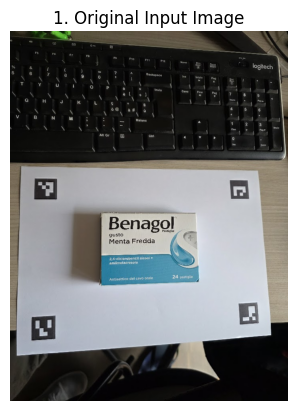

In [4]:
# --- Load Image ---
image_path = args.image
original_input_image_bgr, _ = load_image(image_path)

if original_input_image_bgr is None:
    raise ValueError(f"Could not load image {image_path}")

print(f"Successfully loaded image from: {image_path}")
print(f"Image dimensions (HxWxD): {original_input_image_bgr.shape}")

# Create a working copy of the image that will be modified in each step
image_to_be_processed = original_input_image_bgr.copy()

# Display the original image
plt.imshow(cv2.cvtColor(original_input_image_bgr, cv2.COLOR_BGR2RGB))
plt.title("1. Original Input Image")
plt.axis("off")
plt.show()

# Add to debug pipeline if debug mode is on
if args.debug:
    debug_image_pipeline.append(
        {
            "title": f"{pipeline_step_counter}. Original Input",
            "path": os.path.basename(image_path),
        }
    )
    pipeline_step_counter += 1

# Cell 5: Step 1 - Color Correction
If enabled, this step applies the pre-calculated color correction matrix to the image to standardize the colors.

Applying color correction...
Color correction applied.


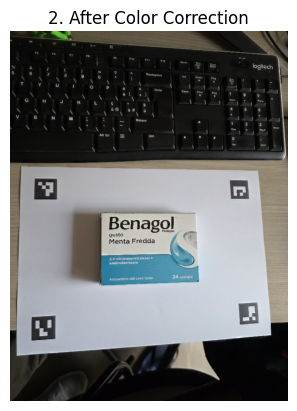

In [5]:
# --- 1. COLOR CORRECTION ---
if args.color_alignment and correction_matrix is not None:
    print("Applying color correction...")
    image_to_be_processed = color_corrector.apply_color_correction(
        image_to_be_processed, correction_matrix
    )

    print("Color correction applied.")

    # Display the result
    plt.imshow(cv2.cvtColor(image_to_be_processed, cv2.COLOR_BGR2RGB))
    plt.title(f"{pipeline_step_counter}. After Color Correction")
    plt.axis("off")
    plt.show()

    if args.debug:
        # (This part would normally be handled by the ReportGenerator)
        # For manual testing, you can save the intermediate step like this:
        output_dir = os.path.join("output", args.project, "debug_steps")
        os.makedirs(output_dir, exist_ok=True)
        path = os.path.join(output_dir, "1_color_corrected.png")
        save_image(path, image_to_be_processed)
        debug_image_pipeline.append(
            {"title": "2. After Color Correction", "path": path}
        )
        pipeline_step_counter += 1
else:
    print("Skipping color correction.")

# Cell 6: Step 2 - Geometrical Alignment
This step uses ArUco markers to align the image, correcting for perspective and rotation.

Performing geometrical alignment...
[DEBUG] Discovering samples in c:\Users\Admin\Documents\Coding\VisualAnalyzer\data\projects\benagol\dataset
[DEBUG] Warning: No valid dataset images found for project 'benagol'.
[DEBUG] Project 'benagol' paths:
[DEBUG]   Reference Color Checker: c:\Users\Admin\Documents\Coding\VisualAnalyzer\data\projects\benagol\dataset\colorchecker\colorchecker.png
[DEBUG]   Color Checker Refs for Project: []
[DEBUG]   Dataset Image Configurations: []
[DEBUG]   ArUco Reference: c:\Users\Admin\Documents\Coding\VisualAnalyzer\data\projects\benagol\dataset\aruco\default_aruco_reference.png
Displaying alignment inputs...


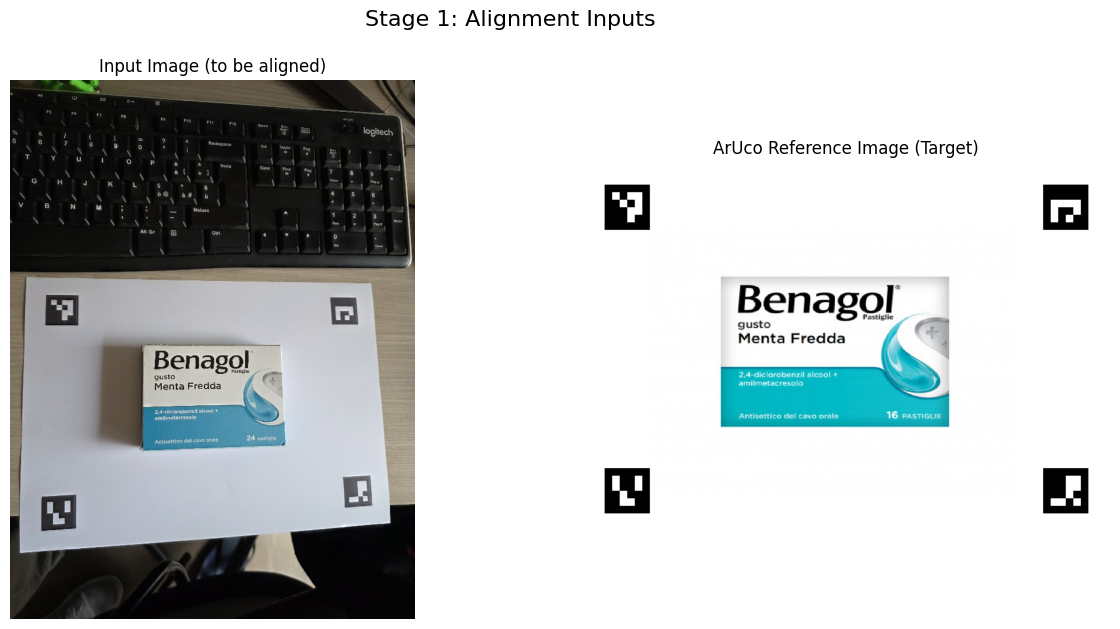

[DEBUG] Alignment to reference successful.
Geometrical alignment successful.


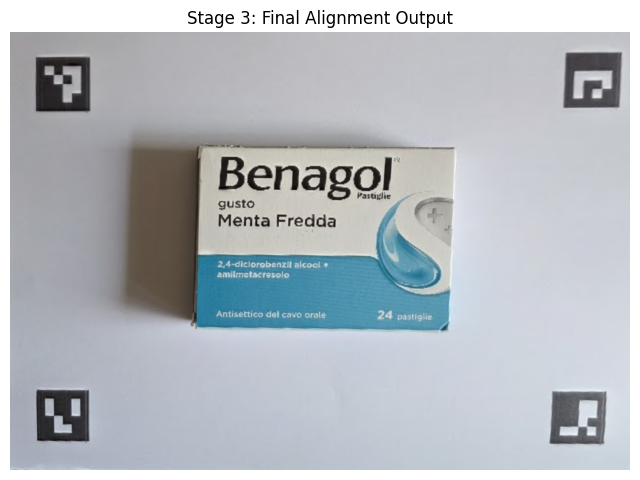

In [6]:
# --- 2. ALIGNMENT ---
if args.alignment:
    print("Performing geometrical alignment...")
    project_files = project_manager.get_project_file_paths(
        args.project, debug_mode=args.debug
    )
    aruco_reference_path = project_files.get("aruco_reference")
    aruco_marker_map = project_files.get("aruco_marker_map")
    aruco_output_size = project_files.get("aruco_output_size")

    # --- Stage 1: Display the inputs for the alignment step ---
    print("Displaying alignment inputs...")
    aruco_reference_image = None
    if aruco_reference_path and os.path.exists(str(aruco_reference_path)):
        aruco_reference_image, _ = load_image(str(aruco_reference_path))

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle("Stage 1: Alignment Inputs", fontsize=16)
    axes[0].imshow(cv2.cvtColor(image_to_be_processed, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Input Image (to be aligned)")
    axes[0].axis("off")
    if aruco_reference_image is not None:
        axes[1].imshow(cv2.cvtColor(aruco_reference_image, cv2.COLOR_BGR2RGB))
        axes[1].set_title("ArUco Reference Image (Target)")
    else:
        axes[1].text(0.5, 0.5, "ArUco Reference Not Found", ha="center", va="center")
        axes[1].set_title("ArUco Reference Image (Target)")
    axes[1].axis("off")
    plt.show()
    # --- End of Stage 1 ---

    # Create a directory for alignment debug output
    step_dir = os.path.join("output", args.project, "debug_steps", "alignment")
    os.makedirs(step_dir, exist_ok=True)

    temp_aligner = Aligner(debug_mode=args.debug, output_dir=step_dir)
    alignment_result = None

    # Perform the alignment
    if aruco_reference_path:
        alignment_result = temp_aligner.align_image(
            image=image_to_be_processed, aruco_reference_path=str(aruco_reference_path)
        )
    elif aruco_marker_map and aruco_output_size:
        alignment_result = temp_aligner.align_image(
            image=image_to_be_processed,
            marker_map=aruco_marker_map,
            output_size_wh=tuple(aruco_output_size),
        )
    else:
        print("[WARNING] Alignment enabled but no ArUco reference was found.")

    if alignment_result and alignment_result[0] is not None:
        aligned_image, alignment_data = alignment_result
        print("Geometrical alignment successful.")

        # --- Stage 2: Detailed Marker Detection and Homography Points Visualization ---
        if args.debug and alignment_data and "source_points" in alignment_data:
            print("Displaying detailed marker detection and homography polygons...")

            fig, axes = plt.subplots(1, 2, figsize=(15, 7))
            fig.suptitle("Stage 2: Marker Detection & Homography Polygons", fontsize=16)

            # Left Plot: Source points on the input image
            # Load the debug image with all markers that your Aligner class already created
            detected_markers_path = os.path.join(
                step_dir, "aruco_debug", "aruco_markers_detected.png"
            )
            if os.path.exists(detected_markers_path):
                input_detection_img = cv2.imread(detected_markers_path)

                # Overlay the source polygon used for homography
                source_points = np.array(
                    alignment_data["source_points"], dtype=np.int32
                ).reshape((-1, 1, 2))
                cv2.polylines(
                    input_detection_img,
                    [source_points],
                    isClosed=True,
                    color=(0, 255, 0),
                    thickness=3,
                )

                axes[0].imshow(cv2.cvtColor(input_detection_img, cv2.COLOR_BGR2RGB))
                axes[0].set_title("Source Polygon on Input Image")
            else:
                axes[0].text(
                    0.5, 0.5, "Debug Image Not Found", ha="center", va="center"
                )
                axes[0].set_title("Source Polygon on Input Image")
            axes[0].axis("off")

            # Right Plot: Destination points on the reference image
            if aruco_reference_image is not None:
                # Manually detect and draw markers on the reference image for a complete picture
                aruco_dict = cv2.aruco.getPredefinedDictionary(
                    cv2.aruco.DICT_5X5_250
                )  # Match dict from your aligner
                params = cv2.aruco.DetectorParameters_create()
                corners, ids, _ = cv2.aruco.detectMarkers(
                    aruco_reference_image, aruco_dict, parameters=params
                )

                reference_with_markers = aruco_reference_image.copy()
                if ids is not None:
                    cv2.aruco.drawDetectedMarkers(reference_with_markers, corners, ids)

                # Overlay the destination polygon
                dest_points = np.array(
                    alignment_data["dest_points"], dtype=np.int32
                ).reshape((-1, 1, 2))
                cv2.polylines(
                    reference_with_markers,
                    [dest_points],
                    isClosed=True,
                    color=(255, 0, 255),
                    thickness=3,
                )

                axes[1].imshow(cv2.cvtColor(reference_with_markers, cv2.COLOR_BGR2RGB))
                axes[1].set_title("Destination Polygon on Reference Image")
            else:
                axes[1].text(
                    0.5, 0.5, "Reference Not Available", ha="center", va="center"
                )
                axes[1].set_title("Destination Polygon on Reference Image")
            axes[1].axis("off")
            plt.show()
        # --- End of Stage 2 ---

        # Update the image for the next step in the pipeline
        image_to_be_processed = aligned_image

        # --- Stage 3: Display the final aligned output ---
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(image_to_be_processed, cv2.COLOR_BGR2RGB))
        plt.title("Stage 3: Final Alignment Output")
        plt.axis("off")
        plt.show()
        # --- End of Stage 3 ---

        if args.debug:
            pipeline_step_counter += 1
    else:
        print(
            "[WARNING] Image alignment failed. The original image will be used for subsequent steps."
        )
else:
    print("Skipping geometrical alignment.")

# Object Alignment

In [7]:
type(image_to_be_processed)

numpy.ndarray

In [8]:
import cv2
import os
import numpy as np

# Make sure to install the necessary library: pip install opencv-python
# This line assumes the AdvancedAligner class from Part 2 is defined in another cell or a .py file
from src.object_alignment.object_aligner import AdvancedAligner


# =================== CORRECTED FUNCTION ===================
def align_image(input_data, reference_path, output_path, method="feature_orb"):
    """
    Aligns an input image to a reference image using the AdvancedAligner.

    Args:
        input_data (str or np.ndarray): Path to the input image OR a pre-loaded image as a NumPy array.
        reference_path (str): Path to the reference image.
        output_path (str): Path to save the aligned output image.
        method (str): The alignment method to use.
    """
    # --- CHANGE START ---
    # Check if the input is a file path (string) or an already loaded image (numpy array)
    if isinstance(input_data, str):
        print(f"Loading input image from path: {input_data}")
        input_image = cv2.imread(input_data)
    elif isinstance(input_data, np.ndarray):
        print("Using pre-loaded NumPy array as input image.")
        input_image = input_data  # Use the array directly
    else:
        print(
            f"Error: Invalid input type: {type(input_data)}. Must be a string path or a NumPy array."
        )
        return
    # --- CHANGE END ---

    if input_image is None:
        print(f"Error: Could not load or use the input image.")
        return

    print(f"Loading reference image from: {reference_path}")
    reference_image = cv2.imread(reference_path)
    if reference_image is None:
        print(f"Error: Could not load reference image at {reference_path}")
        return

    # Initialize the aligner
    aligner = AdvancedAligner()

    print(f"Aligning image using method: '{method}'...")
    aligned_image = aligner.align(input_image, reference_image, method=method)

    if aligned_image is not None:
        # Ensure the output directory exists
        output_dir = os.path.dirname(output_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"Created output directory: {output_dir}")

        cv2.imwrite(output_path, aligned_image)
        print(f"Successfully aligned image and saved it to: {output_path}")
    else:
        print(f"Alignment failed for method: '{method}'")


# --- Configuration ---
# For demonstration, we create a dummy NumPy array.
# In your actual code, 'image_to_be_processed' would already exist from a previous step.
image_to_be_processed = image_to_be_processed

# Set the paths for the reference and output images
reference_image_path = r"data\projects\benagol\dataset\training\016242164.main.jpg"
output_image_path = r"output/aligned_image.png"
alignment_method = "feature_orb"


# --- Execution ---
# Call the function with the numpy array variable
align_image(
    image_to_be_processed, reference_image_path, output_image_path, alignment_method
)

Using pre-loaded NumPy array as input image.
Loading reference image from: data\projects\benagol\dataset\training\016242164.main.jpg
Aligning image using method: 'feature_orb'...
Successfully aligned image and saved it to: output/aligned_image.png


# Cell 7: Step 3 - Image Blurring
If enabled, a blur is applied to the image to reduce noise before color analysis.

In [9]:
# --- 3. BLUR ---
blurred_kernel_size = None
if args.blur:
    print("Applying blur...")
    custom_kernel = tuple(args.blur_kernel) if args.blur_kernel else None

    image_to_be_processed, blurred_kernel_size = blur_image(
        image_to_be_processed, kernel_size=custom_kernel
    )

    print(f"Blur applied with kernel size: {blurred_kernel_size}")

    # Display the result
    plt.imshow(cv2.cvtColor(image_to_be_processed, cv2.COLOR_BGR2RGB))
    plt.title(f"{pipeline_step_counter}. After Blurring")
    plt.axis("off")
    plt.show()

    if args.debug:
        pipeline_step_counter += 1
else:
    print("Skipping blur.")

Skipping blur.


# Cell 8: Step 4 - Color Analysis
This is the core analysis step. It identifies pixels within the specified HSV range and calculates statistics.

Performing color analysis...
[DEBUG] Color analysis performed with HSV range: [ 86  64 155] - [100 253 221]
[DEBUG] Mask before aggregation saved to output\benagol\debug_steps\color_analysis\mask_pre_aggregation_20250914203326232218.png
[DEBUG] Improved aggregating mask with kernel_size=7, min_area_ratio=0.0005, density_thresh=0.5
[DEBUG]   Kept component 1 with area 568306 and density 0.87.
[DEBUG]   Filtered out component 2 with area 49 (too small).
[DEBUG]   Filtered out component 3 with area 350 (too small).
[DEBUG]   Filtered out component 4 with area 161 (too small).
[DEBUG]   Filtered out component 5 with area 147 (too small).
[DEBUG]   Filtered out component 6 with area 472 (too small).
[DEBUG]   Filtered out component 7 with area 640 (too small).
[DEBUG]   Filtered out component 8 with area 91 (too small).
[DEBUG]   Filtered out component 9 with area 266 (too small).
[DEBUG]   Filtered out component 10 with area 91 (too small).
[DEBUG]   Filtered out component 11 with area 540

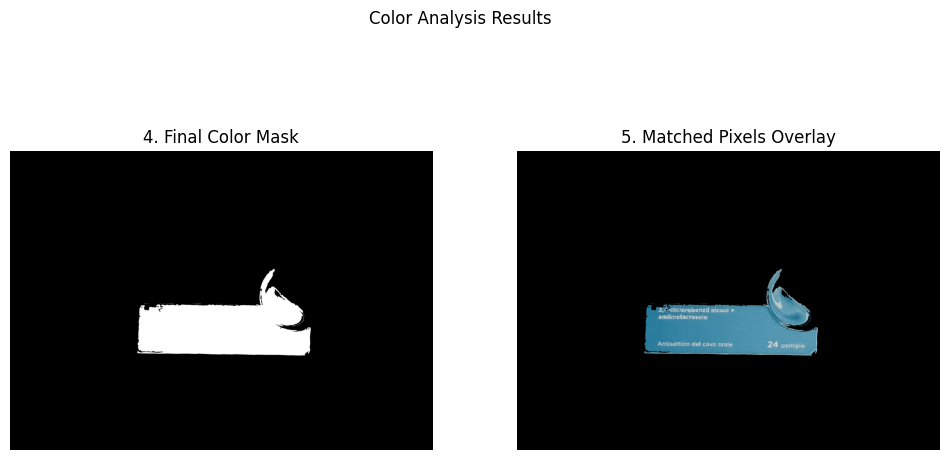

In [10]:
# --- 4. COLOR ANALYSIS ---
print("Performing color analysis...")

# (Create a temporary directory for analysis output)
step_dir = os.path.join("output", args.project, "debug_steps", "color_analysis")
os.makedirs(step_dir, exist_ok=True)

analysis_results = color_analyzer.process_image(
    image=image_to_be_processed,
    image_path=image_path,
    lower_hsv=lower_hsv,
    upper_hsv=upper_hsv,
    output_dir=step_dir,
    debug_mode=args.debug,
    aggregate_mode=args.aggregate,
    agg_kernel_size=args.agg_kernel_size,
    agg_min_area=args.agg_min_area,
    agg_density_thresh=args.agg_density_thresh,
)

print("Color analysis complete.")
print(f"  - Percentage Matched: {analysis_results['percentage']:.2f}%")
print(f"  - Matched Pixels: {analysis_results['matched_pixels']:,}")
print(f"  - Total Pixels: {analysis_results['total_pixels']:,}")

# Display the final processed image and the color mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Color Analysis Results")

# Mask
mask_image = cv2.imread(analysis_results["mask_path"], cv2.IMREAD_GRAYSCALE)
axes[0].imshow(mask_image, cmap="gray")
axes[0].set_title(f"{pipeline_step_counter}. Final Color Mask")
axes[0].axis("off")

# Processed Image with Overlay
processed_img_bgr = analysis_results["processed_image"]
axes[1].imshow(cv2.cvtColor(processed_img_bgr, cv2.COLOR_BGR2RGB))
axes[1].set_title(f"{pipeline_step_counter+1}. Matched Pixels Overlay")
axes[1].axis("off")

plt.show()

# Cell 9: Step 5 - Symmetry Analysis
Using the mask generated in the previous step, this cell calculates various symmetry scores for the detected color regions.

In [11]:
# --- 5. SYMMETRY ANALYSIS ---
symmetry_results = {}
if args.symmetry:
    print("Performing symmetry analysis...")
    mask_path_for_symmetry = analysis_results.get("mask_path")

    if mask_path_for_symmetry and os.path.exists(mask_path_for_symmetry):
        image_for_symmetry, _ = load_image(
            mask_path_for_symmetry, handle_transparency=False
        )

        if image_for_symmetry is not None:
            symmetry_analyzer = SymmetryAnalyzer(image_for_symmetry)
            symmetry_analyzer.analyze_all()
            symmetry_results = symmetry_analyzer.results
            print("Symmetry analysis completed.")

            # Print and display results
            for key, value in symmetry_results.items():
                score = value["score"]
                print(f"  - {key.replace('_', ' ').title()} Score: {score:.4f}")

                # Create and display visualization plot
                fig, axes = plt.subplots(1, 2, figsize=(8, 4))
                fig.suptitle(f"{key.replace('_', ' ').title()} (Score: {score:.4f})")
                axes[0].imshow(symmetry_analyzer.processed_image, cmap="gray")
                axes[0].set_title("Original Mask")

                if "reconstruction" in value:
                    axes[1].imshow(value["reconstruction"], cmap="gray")
                    axes[1].set_title("Ideal Reconstruction")

                for ax in axes:
                    ax.axis("off")
                plt.show()

        else:
            print("[WARNING] Failed to load mask for symmetry analysis.")
    else:
        print("[WARNING] Final color mask not found. Skipping symmetry analysis.")
else:
    print("Skipping symmetry analysis.")

Performing symmetry analysis...


ValueError: too many values to unpack (expected 2)

# Cell 10: Final Step - Report Generation
This final cell gathers all the data collected throughout the pipeline and generates a formal report.

In [ ]:
# --- 6. REPORT GENERATION ---
print("Generating final report...")

# Set up the report generator
sample_name = os.path.splitext(os.path.basename(args.image))[0]
report_generator = ReportGenerator(
    args.project, sample_name=sample_name, debug_mode=args.debug
)

# Gather metadata
metadata = {
    "part_number": sample_name,
    "thickness": "N/A",
}  # Simplified for this example

# Populate final debug data
debug_data_for_report["--- Analysis Results ---"] = ""
debug_data_for_report["Percentage Matched"] = f"{analysis_results['percentage']:.2f}%"
if alignment_data:
    debug_data_for_report["Detected ArUco IDs"] = alignment_data.get("detected_ids")
# ... (add other debug data as needed from the original script) ...
debug_data_for_report["image_pipeline"] = debug_image_pipeline


# Generate the report
report_generator.generate_report(
    analysis_results,
    metadata,
    debug_data=debug_data_for_report,
    report_type=args.report_type,
)

print(
    f"Report generation complete. Check the 'output/{args.project}/{sample_name}' directory."
)

Generating final report...


KeyError: 'selected_colors'

In [ ]:
✦ Of course. Here is how you can use the AdvancedAligner to align an image to a reference.

  First, ensure you have the necessary libraries installed. The main one is opencv-python.


  Here is a Python script that demonstrates how to use the aligner. You can save this as a Python file
  (e.g., align_image.py) and run it from your terminal.


  `python
  import cv2
  import argparse
  from src.object_alignment.object_aligner import AdvancedAligner

  def align_image(input_path, reference_path, output_path, method='feature_orb'):
      """
      Aligns an input image to a reference image using the AdvancedAligner.

      Args:
          input_path (str): Path to the input image to be aligned.
          reference_path (str): Path to the reference image.
          output_path (str): Path to save the aligned output image.
          method (str): The alignment method to use.
      """
      print(f"Loading input image from: {input_path}")
      input_image = cv2.imread(input_path)
      if input_image is None:
          print(f"Error: Could not load input image at {input_path}")
          return

      print(f"Loading reference image from: {reference_path}")
      reference_image = cv2.imread(reference_path)
      if reference_image is None:
          print(f"Error: Could not load reference image at {reference_path}")
          return

      # Initialize the aligner
      aligner = AdvancedAligner()

      print(f"Aligning image using method: '{method}'...")
      aligned_image = aligner.align(input_image, reference_image, method=method)

      if aligned_image is not None:
          cv2.imwrite(output_path, aligned_image)
          print(f"Successfully aligned image and saved it to: {output_path}")
      else:
          print(f"Alignment failed for method: '{method}'")

  if __name__ == "__main__":
      parser = argparse.ArgumentParser(description="Align an image to a reference using AdvancedAligner.")
      parser.add_argument("-i", "--input", required=True, help="Path to the input image.")
      parser.add_argument("-r", "--reference", required=True, help="Path to the reference image.")
      parser.add_argument("-o", "--output", required=True, help="Path to save the aligned image.")
      parser.add_argument("-m", "--method", default='feature_orb',
                          choices=['feature_orb', 'feature_sift', 'ecc', 'contour_centroid', 'polygon'],
                          help="The alignment method to use.")
      args = parser.parse_args()

      align_image(args.input, args.reference, args.output, args.method)
  `


  How to Run the Script
  `bash
  python align_image.py ^
      -i "data/projects/benagol/dataset/training/image.png" ^
      -r "data/projects/benagol/dataset/aruco/default_aruco_reference.png" ^
      -o "output/aligned_benagol.png" ^
      -m "ecc"
  `

  ### Alignment Methods


  The AdvancedAligner class provides several alignment methods. You can choose the one that works best for
  your images:


   * feature_orb (default): Fast and good for most cases. Uses ORB features.
  You can experiment with these methods to see which one gives you the best results for your specific
  images.
